In [113]:
import numpy as np
import matplotlib

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import os
from scipy.misc import derivative
from scipy.integrate import solve_bvp
from functools import partial
from scipy import special as sp
from scipy import stats
import plasmapy.mathematics
import scipy.optimize as op
from functools import partial
from scipy import fftpack
from scipy import integrate
from scipy import signal
%config InlineBackend.figure_format = 'svg'
#%matplotlib notebook

In [168]:
tem = 1
k = 0.1
L = 2*np.pi / k
vmax = 5  # 10 * np.sqrt(tem)
nx = 301
nv = 301
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)
V, X = np.meshgrid(v, x)
dt = 0.02
max_steps  = 10000
data_steps = 10000
data_num = int(max_steps/data_steps)+1
d = 0.5
kappa = 15.0

path = '../data/'

m=1
n=1
q=1
v_th = np.sqrt(2*tem)
l_D = np.sqrt(tem) # $\lambda_D^2$
w_pe = 1
print("data_num = ",data_num)

print("k = ",k)
print('limited time=',2*np.pi/k/dv)
print('real time = ', max_steps*dt)

data_num =  2
k =  0.1
limited time= 1884.9555921538758
real time =  200.0


## 理论公式
$$n_e^* = A[1-\frac{\Delta}{k^2 \lambda^2 \kappa_0} \cos(kx)]^{-\kappa_0-1}$$
$$n_i^* = A[1-\frac{\Delta}{k^2 \lambda^2 \kappa_0} \cos(kx)]^{-\kappa_0-1} + \Delta \cos(kx)$$
$$A^{-1} = \int_0^L [1-\frac{\Delta}{k^2 \lambda^2 \kappa_0} \cos(kx)]^{-\kappa_0-1} dx$$

In [169]:
B = (d/k**2/kappa/l_D**2)


def unnorm_n(x):
    r = (1 - B * np.cos(k*x))**(-kappa-1)
    return r


norm = integrate.quad(unnorm_n, 0, L)
#print(norm)


def ne(x):
    r = L * 1 / norm[0] * unnorm_n(x)
    return r


def ni(x):
    r = ne(x) + d*np.cos(k*x)
    return r


def T_theo(x):
    return tem*ne(x)**(-1.0/(kappa+1))


def f_homo(v, t, kappa):
    if(kappa == 0):
        r = np.sqrt(1./(2.*np.pi*t))*np.exp(-v**2/(2*t))
    else:
        r = np.sqrt(m/(2.*np.pi*t*kappa)) * sp.gamma(kappa+1.5) / \
            sp.gamma(kappa+1) * (1 + m*v**2 / kappa / 2 / t) ** (-kappa-1.5)
    return r


def f_inhomo(x, v, kappa):
    t = T_theo(x)
    if(kappa == 0):
        r = f_homo(v, t, kappa)
    else:
        r = ne(x)*np.sqrt(m/(2.*np.pi*t*kappa)) * sp.gamma(kappa+1.5) / \
            sp.gamma(kappa+1) * (1 + m*v**2 / kappa / 2 / t) ** (-kappa-1.5)
    return r


def fv_nonvec(vv, kk):
    r = integrate.quad(partial(f_inhomo, v=vv, kappa=kk), 0, L)[0]
    return r


fv_theo = np.vectorize(fv_nonvec)

c:\users\rguo\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  if __name__ == '__main__':


## 数据读取

In [162]:
progesses = np.arange(0,data_num,1)

f = []
phi = []

for progess in progesses:
    f_temp = np.loadtxt(os.path.join(path,"data"+str(progess)))
    f.append(f_temp)
    phi_temp = np.loadtxt(os.path.join(path,"phi"+str(progess)))
    phi.append(phi_temp)

## 定态展示

In [163]:
dataet = np.loadtxt(os.path.join(path, "tot_energy"))[0:max_steps]
dataep = np.loadtxt(os.path.join(path, "pot_energy"))[0:max_steps]
dataek = np.loadtxt(os.path.join(path, "kin_energy"))[0:max_steps]

t = np.linspace(0, max_steps, max_steps)

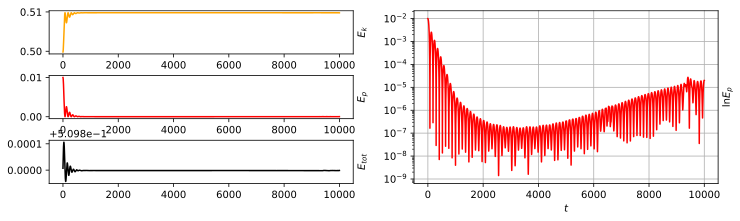

In [164]:
fig = plt.figure(figsize=(12, 3))

ax1 = plt.subplot2grid((3, 2), (0, 0))
ax1.plot(t, dataek, color='orange')
ax1.set_ylabel(r'$E_k$')
ax1.yaxis.set_label_position("right")

ax2 = plt.subplot2grid((3, 2), (1, 0))
ax2.plot(t, dataep, color='r')
ax2.set_ylabel(r'$E_p$')
ax2.yaxis.set_label_position("right")

ax3 = plt.subplot2grid((3, 2), (2, 0))
ax3.plot(t, dataet, color='black')
ax3.set_ylabel(r'$E_{tot}$')
ax3.yaxis.set_label_position("right")

axl2 = plt.subplot2grid((3, 2), (0, 1), rowspan=3)
axl2.plot(t, dataep, color='r')
axl2.set_ylabel(r'$\ln E_p$')
axl2.set_yscale('log')
axl2.yaxis.set_label_position("right")
axl2.grid()

fig.subplots_adjust(bottom=0.1, top=0.9, hspace=.5, wspace=.2)
plt.xlabel(r'$t$')
plt.show()

### 分布函数fx fv

In [165]:
fx0 = np.sum(f[0],axis=1)*dv
fv0 = np.sum(f[0],axis=0)*dx/L
fx = np.sum(f[data_num-1],axis=1)*dv
fv = np.sum(f[data_num-1],axis=0)*dx/L
T0 = np.sum(v**2*f[0],axis=1)*dv/fx0
T = np.sum(v**2*f[data_num-1],axis=1)*dv/fx

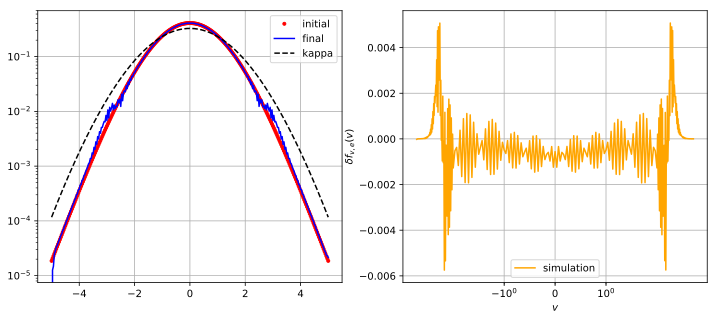

In [166]:
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

ax1.plot(v,fv0,'.',color='r',label='initial')
ax1.plot(v,fv,color='blue',label='final')
ax1.plot(v,1/L*fv_theo(v,kappa),'--',color='black',label='kappa')
ax1.set_yscale('log')

ax2.plot(v, fv-fv0, color='orange', label='simulation')
ax2.set_xlabel(r'$v$')
ax2.set_ylabel(r'$\delta f_{v,e}(v)$')
ax2.set_xscale('symlog')

ax1.legend()
ax2.legend()
ax1.grid()
ax2.grid()
plt.show()

### 密度&温度分布

$$ \frac{n(x)}{n_0}=\left[ \frac{T(x)}{T_0} \right]^{-\kappa_0-1}$$
$$ \nabla \ln T = - \frac{1}{\kappa_0+1} \nabla \ln n$$

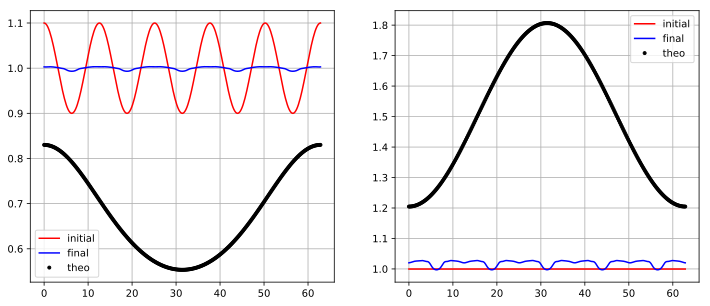

In [167]:
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

ax1.plot(x,fx0,color='r',label='initial')
ax1.plot(x,fx,color='blue',label='final')
ax1.plot(x,ne(x),'.',color='black',label='theo')
#ax1.plot(x,ni(x),'.',color='red',label='theo')

ax2.plot(x,T0,color='r',label='initial')
ax2.plot(x,T,color='blue',label='final')
ax2.plot(x,T_theo(x),'.',color='black',label='theo')

ax1.legend()
ax2.legend()
ax1.grid()
ax2.grid()
plt.show()

LinregressResult(slope=0.20789561782212768, intercept=-0.003371694745367905, rvalue=0.830000968868628, pvalue=8.555188594440049e-78, stderr=0.008079417013113403)


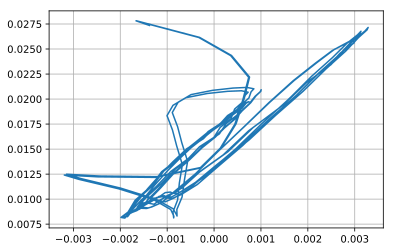

In [160]:
print(stats.linregress(np.log(T),np.log(fx)))
plt.plot(np.log(fx),np.log(T))
plt.grid()
plt.show()

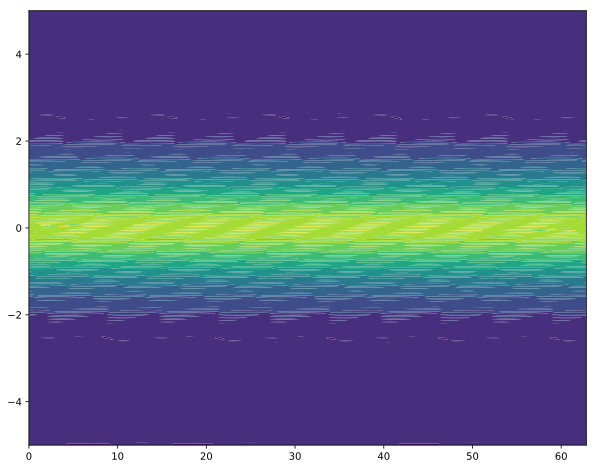

In [161]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot()
Z = f[data_num-1]
plt.contourf(X,V,Z,levels=10)
plt.show()